# 1.8f3: Orthographic Projections from Origin

This notebook visualizes the three-population structure using orthographic projections.

## The Goal

From 1.8f2, we saw the vocabulary forms an ellipsoid-like structure from God's perspective. Now we want to see this structure from multiple angles using orthographic (parallel) projections.

## Coordinate System

We use the cluster's PCA basis:
- **X axis**: Meridian (PC1) → points to 0° longitude
- **Y axis**: Equinox (PC3) → points to 90° longitude
- **Z axis**: North (PC2) → points to north pole (+90° latitude)

## Method

Convert spherical (r,θ,φ) → Cartesian (x,y,z), then plot:
1. **XY plane** (top view, looking down Z)
2. **XZ plane** (front view, looking down Y)
3. **YZ plane** (right view, looking down X)

## Parameters

In [19]:
# Model
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# PCA basis
NORTH_PC = 2   # Z axis
MERIDIAN_PC = 1  # X axis
EQUINOX_PC = 3   # Y axis

# Colors and point sizes
CLUSTER_COLOR = 'red'
HALO_COLOR = 'orange'
BULK_COLOR = 'steelblue'

CLUSTER_SIZE = 3.0
HALO_SIZE = 2.0
BULK_SIZE = 0.5

CLUSTER_ALPHA = 0.8
HALO_ALPHA = 0.6
BULK_ALPHA = 0.2

# Visualization
FIGSIZE = (16, 16)
DPI = 150

## Imports

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [21]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [22]:
# Load W (full vocabulary)
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32).to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")
print(f"  {N:,} tokens in {d:,} dimensions")

Loaded W: torch.Size([151936, 2560])
  151,936 tokens in 2,560 dimensions


In [23]:
# Load reference frame (for PCA basis)
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
eigenvectors = ref_data['W_eigenvectors'].to(device)

print(f"\nLoaded PCA basis: {eigenvectors.shape}")


Loaded PCA basis: torch.Size([2560, 2560])


In [24]:
# Load population masks
pop_path = Path(f"../tensors/{MODEL_NAME}/1.8e_unreachable_tokens.safetensors")
pop_data = load_file(pop_path)

cluster_mask = pop_data['cluster_mask'].cpu().numpy()
halo_mask = pop_data['halo_mask'].cpu().numpy()
bulk_mask = (~pop_data['unreachable_mask']).cpu().numpy()

print(f"\nPopulation masks loaded:")
print(f"  Cluster: {cluster_mask.sum():,} tokens")
print(f"  Halo: {halo_mask.sum():,} tokens")
print(f"  Bulk: {bulk_mask.sum():,} tokens")


Population masks loaded:
  Cluster: 2,212 tokens
  Halo: 1,423 tokens
  Bulk: 148,579 tokens


## Define Cartesian Basis

In [25]:
def get_pc_vector(pcs, index):
    """Get PC vector by index, with sign flip for negative indices."""
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

# Define orthogonal basis
x_axis = get_pc_vector(eigenvectors, MERIDIAN_PC)  # PC1
y_axis = get_pc_vector(eigenvectors, EQUINOX_PC)   # PC3
z_axis = get_pc_vector(eigenvectors, NORTH_PC)     # PC2

print(f"\nCartesian basis defined:")
print(f"  X axis (Meridian): PC{MERIDIAN_PC}")
print(f"  Y axis (Equinox):  PC{EQUINOX_PC}")
print(f"  Z axis (North):    PC{NORTH_PC}")


Cartesian basis defined:
  X axis (Meridian): PC1
  Y axis (Equinox):  PC3
  Z axis (North):    PC2


## Project to Cartesian Coordinates

In [26]:
print("\nProjecting all tokens to Cartesian coordinates...\n")

# Project W onto basis vectors (from origin)
x = (W @ x_axis).cpu().numpy()
y = (W @ y_axis).cpu().numpy()
z = (W @ z_axis).cpu().numpy()

print(f"✓ Cartesian coordinates computed for {N:,} tokens")
print(f"\nCoordinate ranges:")
print(f"  X: [{x.min():.4f}, {x.max():.4f}]")
print(f"  Y: [{y.min():.4f}, {y.max():.4f}]")
print(f"  Z: [{z.min():.4f}, {z.max():.4f}]")


Projecting all tokens to Cartesian coordinates...

✓ Cartesian coordinates computed for 151,936 tokens

Coordinate ranges:
  X: [-0.8047, 0.7260]
  Y: [-0.2110, 0.1736]
  Z: [-0.2167, 0.2751]


## Orthographic Projections: 3-View Layout


Creating orthographic projection views...



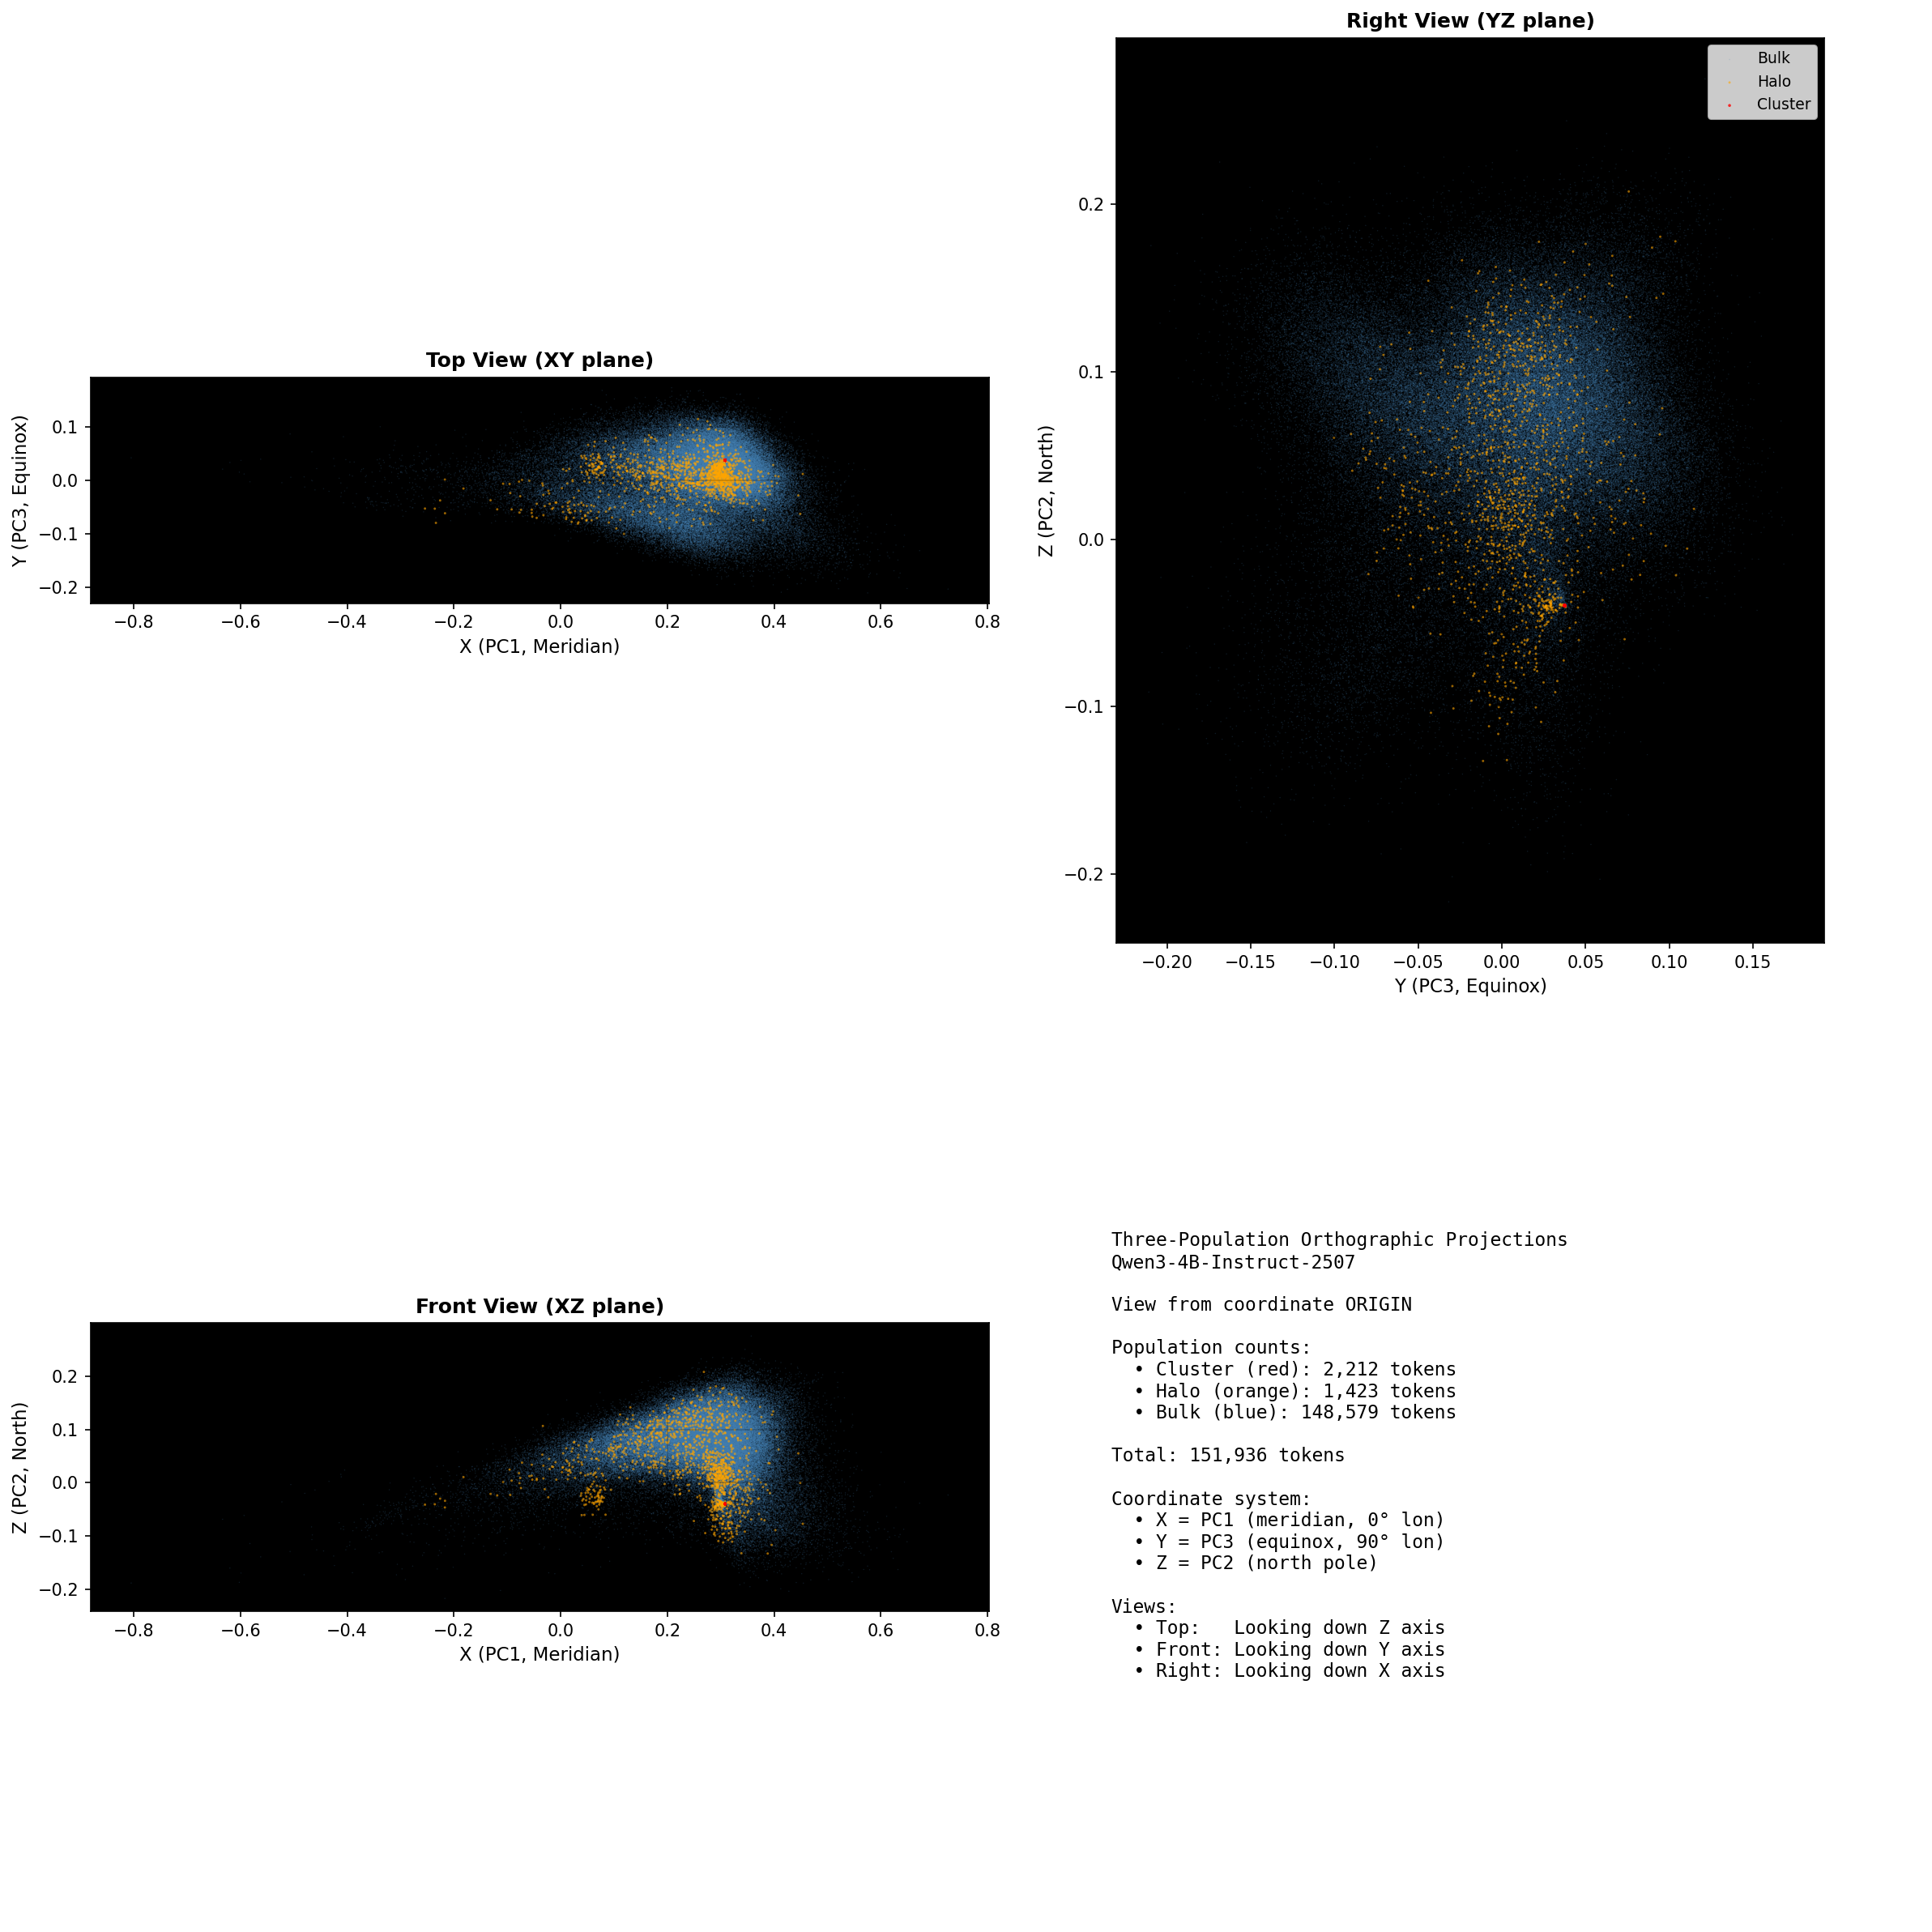

✓ Orthographic projections complete


In [31]:
print("\nCreating orthographic projection views...\n")

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=FIGSIZE, dpi=DPI)

# Set background color for all axes
for ax in axes.flat:
    ax.set_facecolor('black')

# (1,1) XY plane - Top view (looking down Z axis)
ax_xy = axes[0, 0]
ax_xy.scatter(x[bulk_mask], y[bulk_mask], s=BULK_SIZE, alpha=BULK_ALPHA, c=BULK_COLOR, edgecolors='none', rasterized=True)
ax_xy.scatter(x[halo_mask], y[halo_mask], s=HALO_SIZE, alpha=HALO_ALPHA, c=HALO_COLOR, edgecolors='none', rasterized=True)
ax_xy.scatter(x[cluster_mask], y[cluster_mask], s=CLUSTER_SIZE, alpha=CLUSTER_ALPHA, c=CLUSTER_COLOR, edgecolors='none', rasterized=True)
ax_xy.set_xlabel('X (PC1, Meridian)', color='black', fontsize=11)
ax_xy.set_ylabel('Y (PC3, Equinox)', color='black', fontsize=11)
ax_xy.set_title('Top View (XY plane)', color='black', fontsize=12, fontweight='bold')
ax_xy.grid(True, alpha=0.2, color='black')
ax_xy.set_aspect('equal')
ax_xy.tick_params(colors='black')

# (1,2) XZ plane - Front view (looking down Y axis)
ax_xz = axes[1, 0]
ax_xz.scatter(x[bulk_mask], z[bulk_mask], s=BULK_SIZE, alpha=BULK_ALPHA, c=BULK_COLOR, edgecolors='none', rasterized=True)
ax_xz.scatter(x[halo_mask], z[halo_mask], s=HALO_SIZE, alpha=HALO_ALPHA, c=HALO_COLOR, edgecolors='none', rasterized=True)
ax_xz.scatter(x[cluster_mask], z[cluster_mask], s=CLUSTER_SIZE, alpha=CLUSTER_ALPHA, c=CLUSTER_COLOR, edgecolors='none', rasterized=True)
ax_xz.set_xlabel('X (PC1, Meridian)', color='black', fontsize=11)
ax_xz.set_ylabel('Z (PC2, North)', color='black', fontsize=11)
ax_xz.set_title('Front View (XZ plane)', color='black', fontsize=12, fontweight='bold')
ax_xz.grid(True, alpha=0.2, color='black')
ax_xz.set_aspect('equal')
ax_xz.tick_params(colors='black')

# (2,1) YZ plane - Right view (looking down X axis)
ax_yz = axes[0, 1]
ax_yz.scatter(y[bulk_mask], z[bulk_mask], s=BULK_SIZE, alpha=BULK_ALPHA, c=BULK_COLOR, edgecolors='none', rasterized=True, label='Bulk')
ax_yz.scatter(y[halo_mask], z[halo_mask], s=HALO_SIZE, alpha=HALO_ALPHA, c=HALO_COLOR, edgecolors='none', rasterized=True, label='Halo')
ax_yz.scatter(y[cluster_mask], z[cluster_mask], s=CLUSTER_SIZE, alpha=CLUSTER_ALPHA, c=CLUSTER_COLOR, edgecolors='none', rasterized=True, label='Cluster')
ax_yz.set_xlabel('Y (PC3, Equinox)', color='black', fontsize=11)
ax_yz.set_ylabel('Z (PC2, North)', color='black', fontsize=11)
ax_yz.set_title('Right View (YZ plane)', color='black', fontsize=12, fontweight='bold')
ax_yz.grid(True, alpha=0.2, color='black')
ax_yz.set_aspect('equal')
ax_yz.tick_params(colors='black')
ax_yz.legend(loc='upper right', framealpha=0.8, fontsize=9)

# (2,2) Stats/Legend
ax_stats = axes[1, 1]
ax_stats.axis('off')

# Add text with statistics
stats_text = f"""Three-Population Orthographic Projections
{MODEL_NAME}

View from coordinate ORIGIN

Population counts:
  • Cluster (red): {cluster_mask.sum():,} tokens
  • Halo (orange): {halo_mask.sum():,} tokens  
  • Bulk (blue): {bulk_mask.sum():,} tokens

Total: {N:,} tokens

Coordinate system:
  • X = PC1 (meridian, 0° lon)
  • Y = PC3 (equinox, 90° lon)
  • Z = PC2 (north pole)

Views:
  • Top:   Looking down Z axis
  • Front: Looking down Y axis
  • Right: Looking down X axis
"""

ax_stats.text(0.1, 0.5, stats_text, 
              transform=ax_stats.transAxes,
              fontsize=11,
              color='black',
              verticalalignment='center',
              fontfamily='monospace')

plt.tight_layout()
plt.show()

print("✓ Orthographic projections complete")

## Observations

### What the projections reveal:

**If vocabulary is spherically symmetric:**
- All three views show circular distributions
- Equal extent in all directions
- Cluster appears as small core near origin in all views

**If vocabulary is ellipsoidal:**
- Different views show different aspect ratios
- Elongation visible along principal axis (likely X = PC1)
- YZ view (looking down X) shows cross-section of ellipsoid
- XY and XZ views show elongation

**Key questions:**
1. Is the structure elongated along X (PC1)?
2. Are Y and Z extents similar (ellipsoid vs triaxial ellipsoid)?
3. Where is the cluster relative to origin in each view?
4. Does the halo show directional preference?

**Interpretation:**
- PC1 is direction of **maximum variance**, not maximum distance
- Ellipsoidal structure → anisotropic training dynamics
- Tokens expanded preferentially along certain directions
- Origin is initialization point; current structure shows training history